In [16]:
import xml.etree.ElementTree as ET
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [17]:
n = 3200
m = 3685
size_frame = 224
small_size_frame = 32

In [18]:
y_train_bbox_all = np.zeros((m, 4))
y_train_name_all = np.zeros((m, 2))
X_train_all = np.zeros((m, size_frame, size_frame, 3))
X_train_small_all = np.zeros((m, small_size_frame, small_size_frame, 3))

for index in range(0, m):
    xml_file = ET.parse('./train/annotations/Cats_Test' + str(index) +'.xml') 
    w = int(xml_file.find("size/width").text)
    h = int(xml_file.find("size/height").text)

    xmin = int(xml_file.find("object/bndbox/xmin").text) / w
    ymin = int(xml_file.find("object/bndbox/ymin").text) / h
    xmax = int(xml_file.find("object/bndbox/xmax").text) / w
    ymax = int(xml_file.find("object/bndbox/ymax").text) / h

    #y_train_bbox_all
    y_train_bbox_all[index, 0] = xmin
    y_train_bbox_all[index, 1] = ymin
    y_train_bbox_all[index, 2] = xmax
    y_train_bbox_all[index, 3] = ymax
    
    #y_train_name_all
    if xml_file.find("object/name").text == "cat":
        y_train_name_all[index, 0] = 1
    else:
        y_train_name_all[index, 1] = 1

    #X_train_all
    im = cv.imread('./train/images/Cats_Test' + str(index) + '.png')
    im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    resized_im = (cv.resize(im, (size_frame, size_frame))) / 255.0
    X_train_all[index] = resized_im

    #X_train_small_all
    cropped_im = resized_im[int(ymin* size_frame):int(ymax* size_frame),
                    int(xmin* size_frame):int(xmax* size_frame)]
    X_train_small_all[index] = cv.resize(cropped_im, (small_size_frame, small_size_frame))


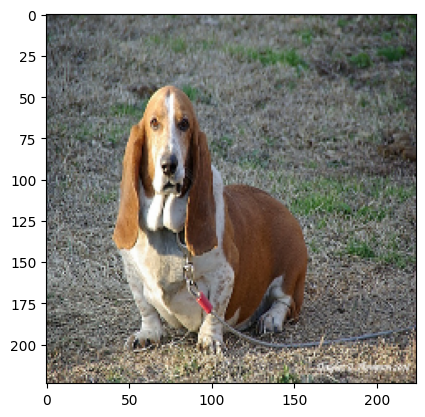

In [19]:
plt.imshow(X_train_all[237])

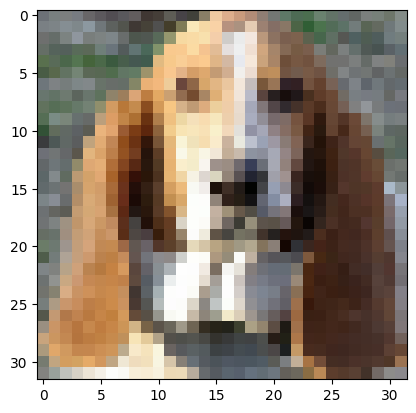

In [20]:
plt.imshow(X_train_small_all[237])

In [30]:
X_train = X_train_all[:n]
y_train_bbox = y_train_bbox_all[:n]
X_train_small = X_train_small_all[:n]
y_train_name = y_train_name_all[:n]


X_test = X_train_all[n:]
y_test_bbox = y_train_bbox_all[n:]
X_test_small = X_train_small_all[n:]
y_test_name = y_train_name_all[n:]

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

2024-03-01 18:14:40.964169: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 18:14:40.964211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 18:14:40.966850: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 18:14:40.998095: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-01 18:14:42.009978: W tensorflow/compiler/tf2

In [23]:
vgg = VGG16(weights="imagenet", include_top=False,
            input_tensor=Input(shape=(size_frame, size_frame, 3)))

vgg.trainable = False

flatten = vgg.output
flatten = Flatten()(flatten)

bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

model = Model(inputs=vgg.input, outputs=bboxHead)

optimizer = Adam(learning_rate=0.001)
model.compile(loss="mse", optimizer=optimizer)
model.summary()

2024-03-01 18:14:42.884701: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 18:14:43.000765: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 18:14:43.001017: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [24]:
model.fit(x=X_train, y=y_train_bbox, batch_size=32, epochs=20)

2024-03-01 18:14:54.036670: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1926758400 exceeds 10% of free system memory.
2024-03-01 18:14:57.151259: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1926758400 exceeds 10% of free system memory.


Epoch 1/20


2024-03-01 18:15:02.181970: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-01 18:15:03.490714: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-01 18:15:05.986733: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-01 18:15:06.491060: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f50a6d37fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-01 18:15:06.491084: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-03-01 18:15:06.506483: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709306106.625771   17657 device_compiler.

100/100 [==============================] - 19s 97ms/step - loss: 0.0662
Epoch 2/20
100/100 [==============================] - 10s 97ms/step - loss: 0.0206
Epoch 3/20
100/100 [==============================] - 10s 98ms/step - loss: 0.0053
Epoch 4/20
100/100 [==============================] - 10s 98ms/step - loss: 0.0035
Epoch 5/20
100/100 [==============================] - 10s 97ms/step - loss: 0.0024
Epoch 6/20
100/100 [==============================] - 10s 97ms/step - loss: 0.0018
Epoch 7/20
100/100 [==============================] - 10s 97ms/step - loss: 0.0015
Epoch 8/20
100/100 [==============================] - 10s 99ms/step - loss: 0.0013
Epoch 9/20
100/100 [==============================] - 10s 98ms/step - loss: 9.9846e-04
Epoch 10/20
100/100 [==============================] - 10s 98ms/step - loss: 8.5823e-04
Epoch 11/20
100/100 [==============================] - 10s 98ms/step - loss: 7.2946e-04
Epoch 12/20
100/100 [==============================] - 10s 99ms/step - loss: 6.4917e

Теперь нейронка для распознавания собаки или кошки

In [27]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(32,32,3), padding="same", activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(2, activation="softmax")
])

model2.compile(optimizer="Adam", loss="mse")

In [28]:
model2.fit(x=X_train_small, y=y_train_name, batch_size=32, epochs=20)

Epoch 1/20


2024-03-01 18:18:43.153570: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - 5s 7ms/step - loss: 0.2113
Epoch 2/20
100/100 [==============================] - 1s 6ms/step - loss: 0.1211
Epoch 3/20
100/100 [==============================] - 1s 6ms/step - loss: 0.0954
Epoch 4/20
100/100 [==============================] - 1s 6ms/step - loss: 0.0739
Epoch 5/20
100/100 [==============================] - 1s 7ms/step - loss: 0.0682
Epoch 6/20
100/100 [==============================] - 1s 6ms/step - loss: 0.0521
Epoch 7/20
100/100 [==============================] - 1s 6ms/step - loss: 0.0462
Epoch 8/20
100/100 [==============================] - 1s 6ms/step - loss: 0.0401
Epoch 9/20
100/100 [==============================] - 1s 6ms/step - loss: 0.0338
Epoch 10/20
100/100 [==============================] - 1s 6ms/step - loss: 0.0311
Epoch 11/20
100/100 [==============================] - 1s 6ms/step - loss: 0.0300
Epoch 12/20
100/100 [==============================] - 1s 6ms/step - loss: 0.0279
Epoch 13/20
100/100 [===============

In [32]:
model2.evaluate(X_test_small, y_test_name)

16/16 [==============================] - 0s 10ms/step - loss: 0.0719


0.07186315953731537

In [33]:
pred = model.predict(X_test)

16/16 [==============================] - 2s 124ms/step


TypeError: slice indices must be integers or None or have an __index__ method

In [66]:
pred_im = np.zeros((m-n, small_size_frame, small_size_frame, 3))
for i in range(0, m-n):
    pred_im[i] = cv.resize(X_test[i][int(pred[i,1]*size_frame):
                            int(pred[i,3]*size_frame),
                            int(pred[i,0]*size_frame):
                            int(pred[i,2]*size_frame)], (small_size_frame, small_size_frame))

In [78]:
pred2 = model2.predict(pred_im)

16/16 [==============================] - 0s 2ms/step


[0.9440892  0.05591087]


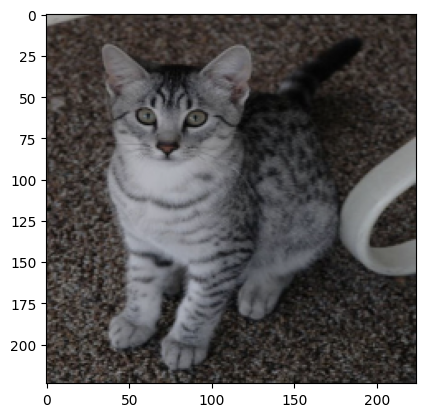

In [98]:
e = 29
# (cat, dog)
print(pred2[e])
plt.imshow(X_test[e])